# LZW demonstrator

The aim of this note is to  provide some reference facts for LZW---mostly from Thomas and Cover \cite{Cover:2006aa}---adapted to the needs of the  Luminous project. LZW is an algorithm to compute a Kolmogorov Complexity estimate derived from a limited set of programs that only allow copy and insertion in strings (not Turing complete set). Despite its simplicity, it is rather powerful and fast. We focus on definitions of LZW derived complexity consistent with the notion of descriptive length, and discuss different normalizations, which result in a set of metrics we call $\rho_0$ and $\rho_1$.

In [1]:
# LZW Update May 2017, Feb 12 2017 to match TN00344. 
# G. Ruffini with Eleni Kroupi / Starlab + Neuroelectrics (2017)
# Updated May 2017 with Entropy rate calculators
# Part of this code from sources as indicated, but modified to 
# be used with binary data.

# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in 
# the Software without restriction, including without limitation the rights to 
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so, 
# subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all 
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR 
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR 
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER 
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# # CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.      



import numpy as np
##########################################################################

def binarizeby(data, method="median"):
    """ Binarize 1D numpy data array using different methods: mean or median"""
    
    d=data*0
    if method == "median":
        thr=np.median(data)
        d[np.where(data>= thr)]=1
        print " Using median as threshold"
        print " The median is:", str(thr)
                                    
    else: # use mean
        thr=np.mean(data)
        d[np.where(data>= thr)]=1
        print " Using mean as threshold"
        print " The mean is:", str(thr)
    print " Binarized data average", str(np.mean(d.astype(np.int8)))
    return d.astype(np.int8)


# adapted from https://rosettacode.org/wiki/LZW_compression#Python
def compress(theString,mode='binary',verbose=True):
    """Compress a *string* to a list of output symbols. Starts from two sympols, 0 and 1. 
       Returns the compressed string and the length of the dictionary
       If you need to, convert first arrays to a string , 
       e.g., entry="".join([np.str(np.int(x)) for x in theArray]) """
 
    if mode == 'binary':
        dict_size=2
        dictionary={'0':0, '1':1}
    elif mode=='ascii':
        # Build the dictionary for generic ascii.
        dict_size = 256
        dictionary = dict((chr(i), i) for i in xrange(dict_size))
    else:
        print "unrecognized mode, please use binary or ascii"
    w = ""
    result = []
    for c in theString:
        wc = w + c

        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            # Add wc to the dictionary.
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
 
    # Output the code for w.
    if w:
        result.append(dictionary[w])
    if verbose:    
        print "length of input string:", len(theString)    
        print "length of dictionary:", len(dictionary)
        print "length of result:", len(result)
    return result,len(dictionary)



def decompress(compressed,mode='binary'):
    """Decompress a list of output ks to a string."""
    from cStringIO import StringIO
 
    if mode == 'binary':
        dict_size=2
        dictionary={0:'0', 1:'1'}
        w = str(compressed.pop(0))


    elif mode=='ascii':
        # Build the dictionary for generic ascii.
        dict_size = 256
        dictionary = dict((i, chr(i)) for i in xrange(dict_size))
        w = chr(compressed.pop(0))

    else:
        print "unrecognized mode, please use binary or ascii"

    # use StringIO, otherwise this becomes O(N^2)
    # due to string concatenation in a loop
    result = StringIO()
    result.write(w)

    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError('Bad compressed k: %s' % k)
        result.write(entry)
 
        # Add w+entry[0] to the dictionary.
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
 
        w = entry
    return result.getvalue()
      
    
    
############################################################################## 
                      
def Compute_rho0(theArray):
    """Computes rho0 metric (bits/Sample) as described in TN000344 Starlab / Luminous """

    return    ComputeDescriptionLength(theArray) / len(theArray)*1.0   

def Compute_rho1(theArray):
    """Computes rho1 metric (bits/Sample) as described in TN000344 /Starlab Luminous"""

    return    ComputeDescriptionLength(theArray) / ShannonEntropy(theArray)  / len(theArray)

def Compute_rho2(theArray):
    """Computes rho2 metric (bits/Sample) as described in TN00044 """

    return    Compute_rho0(theArray)- ShannonEntropy(theArray)  


def ComputeDescriptionLength(theArray,classic=False):
    """Computes description lenght l_{LZW} as described in TN000344"""

    entry="".join([np.str(np.int(x)) for x in theArray])   
    
    compressedstring,len_dict=compress(entry)  # returns 
    ndigits=len(np.unique(theArray))
    print "distinct digits:", ndigits
    

    
    # you need n bits log(max(comp))) to describe this sequence. And there are this many: len(a)...
    # DL: "you need n bits. There are these (m) of them".

    DL=np.log2(np.log2(max(compressedstring)))+ np.log2(max(compressedstring))*len(compressedstring)
    
    if classic:
    # old way ... more for LZ than LZW:
      DL= len_dict*np.log2(len_dict)
    
    return DL

def ShannonEntropy(labels):
    """ Computes entropy of label distribution. numpy array int in """
    n_labels = len(labels)
    if n_labels <= 1:
        return 0

    counts = np.bincount(labels)
    probs = counts*1.0 / n_labels*1.0
    n_classes = np.count_nonzero(probs)
  
    if n_classes <= 1:
        return 0
    
    # Compute standard entropy.
    ent = 0.
    for i in probs:
        ent -= i * np.log2(i)

    return ent


##########################################################################
# Entropy rate of English ...

import re, codecs, random, math, textwrap
from collections import defaultdict, deque, Counter

def ComputeER(theArray, markov_order=4):
        """ Compute entropy rate of array with some memomory / markov_order"""
        # compute entropy rate ...
        #np.savetxt("rule.txt",  theArray.astype(int),fmt='%i', delimiter="")
        #model, stats = markov_model(chars("rule.txt"), markov_order)
        datastream=streamArray(theArray.astype(int))
        model, stats = markov_model(datastream, markov_order)
        del datastream
        return entropy_rate(model, stats)
    
    
def streamArray(theArray):
    """Generator for array elements (convenient)"""
    for element in theArray:
        yield element
        

# The following 3 are adapted from:  
# Clement Pit--Claudel (http://pit-claudel.fr/clement/blog)
def markov_model(stream, model_order):
    """model describes prob of a digit appearing following n prior ones"""
    """ Stats provide frequencies of groups of n symbols"""
    model, stats = defaultdict(Counter), Counter()
    circular_buffer = deque(maxlen = model_order)
    
    for token in stream:
        prefix = tuple(circular_buffer)
        circular_buffer.append(token)
        if len(prefix) == model_order:
            stats[prefix] += 1.0
            model[prefix][token] += 1.0
    return model, stats

def entropy(stats, normalization_factor):
    return -sum(proba / normalization_factor * math.log(proba 
                    / normalization_factor, 2) for proba in stats.values())

def entropy_rate(model, stats):

    return sum(stats[prefix] * entropy(model[prefix], stats[prefix]) 
               for prefix in stats) / sum(stats.values())




    

# Examples of use

In [2]:
#Example of How to use this:
theString='TOBEORNOTTOBEORTOBE ORNOTTOBEORNOTTOBEORTOBEORNOTTOBEORNOTTOBEORTOBEORNOT 0101100101'
print theString


compressed,_ = compress(theString,mode='ascii')
print "\nThe compressed string:", compressed

print "\nNow let's decompress it:", decompress(compressed, mode='ascii')


TOBEORNOTTOBEORTOBE ORNOTTOBEORNOTTOBEORTOBEORNOTTOBEORNOTTOBEORTOBEORNOT 0101100101
length of input string: 84
length of dictionary: 296
length of result: 41

The compressed string: [84, 79, 66, 69, 79, 82, 78, 79, 84, 256, 258, 260, 265, 69, 32, 260, 262, 264, 257, 259, 261, 263, 268, 267, 274, 271, 277, 280, 276, 273, 266, 82, 278, 284, 32, 48, 49, 291, 292, 291, 291]

Now let's decompress it: TOBEORNOTTOBEORTOBE ORNOTTOBEORNOTTOBEORTOBEORNOTTOBEORNOTTOBEORTOBEORNOT 0101100101


In [3]:
#Another example of How to use this:
theString='111110111110111110111110111110111110111110111110111110111110'
theString='1111101'*10


print theString


compressed,_ = compress(theString,mode='binary')
print "\nThe compressed string:", compressed

print "\nNow let's decompress it:", decompress(compressed, mode='binary')

1111101111110111111011111101111110111111011111101111110111111011111101
length of input string: 70
length of dictionary: 21
length of result: 20

The compressed string: [1, 2, 2, 0, 3, 3, 5, 6, 1, 8, 6, 11, 7, 9, 10, 15, 13, 4, 17, 20]

Now let's decompress it: 1111101111110111111011111101111110111111011111101111110111111011111101


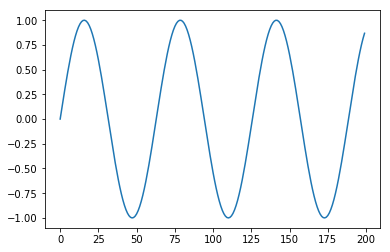

In [4]:
# create a random number list
#datalist= [np.sin(np.random.normal(0)) for n in np.arange(0,1e6)]
datalist= [np.sin(n/10.) for n in np.arange(0,1e6)]
#datalist= [1 for n in np.arange(0,1e6)]

# convert to np.array
theArray = np.array(datalist)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(theArray[0:200])
plt.show()


In [5]:
print "the raw array:",theArray[0:10]

the raw array: [ 0.          0.09983342  0.19866933  0.29552021  0.38941834  0.47942554
  0.56464247  0.64421769  0.71735609  0.78332691]


In [6]:
# binarize it
binArray=binarizeby(theArray, method="median")
print "the binarized array:", binArray[0:10]

 Using median as threshold
 The median is: 5.91872056627e-05
 Binarized data average 0.5
the binarized array: [0 1 1 1 1 1 1 1 1 1]


The description length of the sequence encoded by LZW  would have length less or equal to the number of phrases times the number of bits needed to identify a seen phrase plus the bits to specify a new symbol (to form a new phrase), hence
\begin{equation}
l_{LZW} \le c(n) \log_{2} \left[ c(n)+ \log_{2} A \right] \approx c(n) \log_{2} \left[ c(n)\right]
\end{equation}



In [7]:
print int(ComputeDescriptionLength(binArray,classic=True))

length of input string: 1000000
length of dictionary: 12630
length of result: 12629
distinct digits: 2
172078


Actually, we can do a bit better than this. In practice, not all dictionary entries are used. We can use the max dictionary key ID and state that "n bits are needed to describe any key entry, and there are m of them (here they are)", leading to 
$
l_{LZW} \le \log_{2}(\log_{2}  \max(output))+ \mbox{length}(output) *  \log_{2} \left[  \max(output) \right]
$, 
since we need $ \log_{2}(\log_{2}  \max(output))$  bits to describe $n$. This is how it is implemented in the appended code.


In [8]:
int(ComputeDescriptionLength(binArray,classic=False))

length of input string: 1000000
length of dictionary: 12630
length of result: 12629
distinct digits: 2


172056

In [9]:
# compute rho0 metric 
rho0=Compute_rho0(binArray)
print "compressed information ratio (bits/Sample)=", '{:.2f}'.format(rho0)

length of input string: 1000000
length of dictionary: 12630
length of result: 12629
distinct digits: 2
compressed information ratio (bits/Sample)= 0.17


In [10]:
print "compressed information ratio (bits/Sample)=", '{:.2f}'.format(ComputeER(binArray,markov_order=4))

compressed information ratio (bits/Sample)= 0.20
